# Import dependencies 

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import  Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


## Load Images 

In [14]:
def load_images(folder, label, size=(244, 244)):
    data = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, size)
            data.append((img, label))
    return data

In [15]:
base_path = "/home/uppercase/Workspace/Lab Projects/ML/deepfake_detection"

train_real = f"{base_path}/Dataset/Train/Real"
train_fake = f"{base_path}/Dataset/Train/Fake"

test_real = f"{base_path}/Dataset/Test/Real"
test_fake = f"{base_path}/Dataset/Test/Fake"

val_real = f"{base_path}/Dataset/Validation/Real"
val_fake = f"{base_path}/Dataset/Validation/Fake"

In [ ]:
base_path = "/home/uppercase/Workspace/Lab Projects/ML/deepfake_detection/Dataset"

IMG_SIZE = (256,256)
BATCH_SIZE = 32

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [18]:
train_generator = train_datagen.flow_from_directory(
    directory=f"{base_path}/Train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb' 
)

val_generator = val_test_datagen.flow_from_directory(
    directory=f"{base_path}/Validation",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    directory=f"{base_path}/Test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb' ,
    shuffle=False
)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [19]:
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Train samples: 140002
Validation samples: 39428
Test samples: 10905


## Build Model 

In [20]:
print(tf.config.list_physical_devices('GPU'))

[]


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(256,256,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])


In [22]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import clear_output

class PlottingCallback(tf.keras.callbacks.Callback):
    """
    A custom callback to plot training and validation metrics after each epoch.
    """
    def on_train_begin(self, logs=None):
        # Initialize dictionaries to store the history of metrics
        self.metrics = {}
        for metric in self.params['metrics']:
            self.metrics[metric] = []
            if 'val_' + metric in self.params['metrics']:
                 self.metrics['val_' + metric] = []

    def on_epoch_end(self, epoch, logs=None):
        # At the end of each epoch, append the metric values
        for metric, value in logs.items():
            if metric in self.metrics:
                self.metrics[metric].append(value)
        
        # Clear the previous plot
        clear_output(wait=True)
        
        # Determine the number of metrics to plot
        num_metrics = len(self.metrics) // 2
        
        # Create a figure to plot the metrics
        plt.figure(figsize=(12, 5 * num_metrics))
        
        # Plot each metric
        for i, (metric, val_metric) in enumerate(zip(
            [m for m in self.metrics if not m.startswith('val_')],
            [m for m in self.metrics if m.startswith('val_')]
        )):
            plt.subplot(num_metrics, 2, 2*i + 1)
            plt.plot(self.metrics[metric], label=f'Training {metric}')
            plt.title(f'Training {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()

            plt.subplot(num_metrics, 2, 2*i + 2)
            plt.plot(self.metrics[val_metric], label=f'Validation {metric}')
            plt.title(f'Validation {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()
            
        plt.tight_layout()
        plt.show()

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopper = EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)

plotting_callback = PlottingCallback()

history = model.fit(
    train_generator,
    epochs=50, 
    validation_data=val_generator,
    callbacks=[early_stopper, plotting_callback]
)

KeyError: 'metrics'

In [23]:
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=7
)

Epoch 1/7
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 5691s 1s/step - accuracy: 0.7219 - loss: 0.5573 - val_accuracy: 0.5810 - val_loss: 0.9926
Epoch 2/7
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 5839s 1s/step - accuracy: 0.8536 - loss: 0.3469 - val_accuracy: 0.8754 - val_loss: 0.2970
Epoch 3/7
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 5814s 1s/step - accuracy: 0.8978 - loss: 0.2621 - val_accuracy: 0.8818 - val_loss: 0.2873
Epoch 4/7
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 5775s 1s/step - accuracy: 0.9154 - loss: 0.2209 - val_accuracy: 0.8716 - val_loss: 0.3762
Epoch 5/7
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 5905s 1s/step - accuracy: 0.9275 - loss: 0.1902 - val_accuracy: 0.8434 - val_loss: 0.4508
Epoch 6/7
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 6050s 1s/step - accuracy: 0.9312 - loss: 0.1813 - val_accuracy: 0.8833 - val_loss: 0.3207
Epoch 7/7
1564/4376 ━━━━━━━━━━━━━━━━━━━━ 1:03:22 1s/step - accuracy: 0.9395 - loss: 0.1610

KeyboardInterrupt: 

In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")
 

/home/uppercase/Workspace/.venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 91s 266ms/step - accuracy: 0.8175 - loss: 0.5027
Test Accuracy: 81.75%


In [26]:
model.save("deepfake_detection_model.h5")

In [ ]:
import matplotlib.pyplot as plt 

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

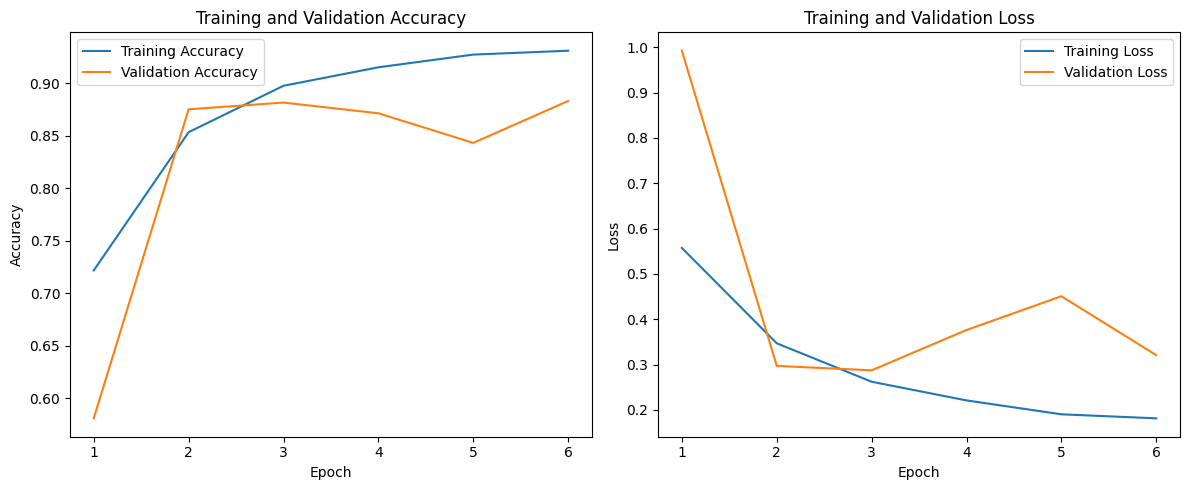

In [27]:
import matplotlib.pyplot as plt

# Manually create lists from your training output
acc = [0.7219, 0.8536, 0.8978, 0.9154, 0.9275, 0.9312]
val_acc = [0.5810, 0.8754, 0.8818, 0.8716, 0.8434, 0.8833]
loss = [0.5573, 0.3469, 0.2621, 0.2209, 0.1902, 0.1813]
val_loss = [0.9926, 0.2970, 0.2873, 0.3762, 0.4508, 0.3207]
epochs_ran = range(1, len(acc) + 1)

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, label='Training Accuracy')
plt.plot(epochs_ran, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss, label='Training Loss')
plt.plot(epochs_ran, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()